Group Name: Group 16

Group Members: Adam Jansen, Jacob King, Nikhil Pyndiah

Group Emails: A: ajans048@uottawa.ca J: jking033@uottaw.ca N: npynd031@uottwa.ca

Group Student #: A:300076841 J:300082223 N:300090426

In [59]:
#FN score he got was around 90% in macro, more then 80
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot

# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_validate

# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier #Will identify the maority calss base line, model needs to do better then the baseline

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# to reduce randomness then you put the seed
np.random.seed(42)

##### Data loading and exploratory analysis (18/100)

Test Data shape: 
(615, 14)

Test Data size: 
8610

Test Data ndim: 
2

_____________________________________________

dataframe columns: 
['Age' 'Sex' 'ALB' 'ALP' 'ALT' 'AST' 'BIL' 'CHE' 'CHOL' 'CREA' 'GGT'
 'PROT']

dataframe datatypes:

Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
split        object
category      int64
dtype: object


_____________________________________________

Sex Distribution:
m    377
f    238
Name: Sex, dtype: int64

_____________________________________________

dataframe class distribution:

0 = HepC Negative, 1 = HepC Positive:

0    540
1     75
Name: category, dtype: int64
Percent With HepC: 
0.12195121951219512

_____________________________________________

Median Age without Hep C:
category
0    47.0
Name: Age, dtype: float64

________________________________

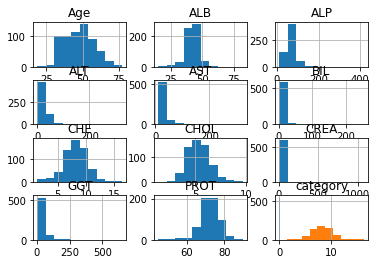

In [45]:
# load the dataset (1)
df = pd.read_csv('./data/hcv_data_split.csv')
# print the dimensionality of the dataframe (1)
print(f"Test Data shape: \n{df.shape}\n")
print(f"Test Data size: \n{df.size}\n")
print(f"Test Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")


# print the names of the columns that can be used as features when training the machine learning model (1)
columnArray = df.copy().drop(['category','split'],axis=1)
columnArray = columnArray.columns.values
print(f"dataframe columns: \n{columnArray}\n")

# print the different data types that can be identified from the entire dataset (1)
print(f"dataframe datatypes:\n")
print(df.dtypes)
print("\n")
print("_____________________________________________\n")

# print the gender distribution in the complete dataset(i.e., the number of male and female individuals) (1)
print(f"Sex Distribution:\n{df['Sex'].value_counts()}\n")
print("_____________________________________________\n")

# print the class distribution of the entire dataset (1)
print(f"dataframe class distribution:\n")
print(f"0 = HepC Negative, 1 = HepC Positive:\n")
print(df['category'].value_counts())
print(f"Percent With HepC: \n{df['category'].value_counts()[1]/ df.shape[0] }\n")
print("_____________________________________________\n")


# print the median age of patients in the dataset having the hepatitis C infection (1.5)
print(f"Median Age without Hep C:\n{df.groupby(['category']).median().head(1)['Age']}\n")
print("_____________________________________________\n")

# print the mean age of individuals in the dataset who does not have hepatitis C infection(i.e., the control group) (1.5)
print(f"Mean Age with Hep C:\n{df.groupby(['category']).mean().tail(1)['Age']}\n")
print("_____________________________________________\n")

# split the dataset into train and test based on the field "split" (0.5 + 0.5)
df.sort_values (by=["split"])
splitCounts = (df['split'].value_counts())
testNum = (splitCounts.iloc[1])
trainNum = (splitCounts.iloc[0])

train_df = df.copy().head(trainNum)
test_df = df.copy().tail(testNum)

# print the dimensionality of the test dataset (0.5)
print(f"Test Data shape: \n{test_df.shape}\n")
print(f"Test Data size: \n{test_df.size}\n")
print(f"Test Data ndim: \n{test_df.ndim}\n")
print("_____________________________________________\n")

# print the dimensionality of the training dataset (0.5)

print(f"Train Data shape: \n{train_df.shape}\n")
print(f"Train Data size: \n{train_df.size}\n")
print(f"Train Data ndim: \n{train_df.ndim}\n")
print("_____________________________________________\n")

# print the proportional distribution of the classes to identify whether or not the classes are equally(or closer) distributed between the train and test datasets (1 + 1)
print(f"Train DF class distribution:\n")
print(f"Percent With HepC: \n{train_df['category'].value_counts()[1]/ train_df.shape[0] }\n") #The Train dataset has a slight (~0.4%) over-representation of Hep-C positive rows
print("_____________________________________________\n")

print(f"Test DF class distribution:\n")
print(f"Percent With HepC: \n{test_df['category'].value_counts()[1]/ test_df.shape[0] }\n")
print("_____________________________________________\n")

# analyze the distribution of the individual features(i.e., by using the complete dataset) and plot a feature that has a rough approximation of a Gaussian distribution (2)
df.hist() # Complete dataset plot

df["CHE"].hist() #Most gaussian feature

# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)
corr_features = []
corr_matrix = df.corr()
for col in corr_matrix.columns: #Iterates over the columns in the correlation matrix
    for ind in corr_matrix.index: #iterates over the rows in the correlation matrix
        if((corr_matrix.at[ind,col]>0.5 or corr_matrix.at[ind,col]<-0.5) and  corr_matrix.at[ind,col]!=1.0 ): #Finds significant correlations within the above matrix
            
            item = (col,ind,corr_matrix.at[ind,col])
            if (item not in corr_features and (item[1],item[0],item[2]) not in corr_features): # If a certain strong correlation (and its reverse) are not recorded, add it to the array
                corr_features+= [item]
print (corr_features)
        

##### Model development (64/100)

In [46]:
# separate the features and the labels to be used in model development (2)

# assume label is 'category' and features are everything else
labels = df.copy()
labels = labels.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category

label_train = train_df.copy()
label_train = label_train.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category for the train df

label_test = test_df.copy()
label_test = label_test.drop(['Age','Sex','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT','PROT','split'],axis=1) #Drop all except category for the test df

print(f"Labels: \n{labels}\n")
features =df.copy()
features = features.drop(['category'],axis=1)
print(f"Features: \n{features}\n")

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(f"Data shape: \n{df.shape}\n")
print(f"Data size: \n{df.size}\n")
print(f"Data ndim: \n{df.ndim}\n")
print("_____________________________________________\n")
print(f"Label shape: \n{labels.shape}\n")
print(f"Label size: \n{labels.size}\n")
print(f"Label ndim: \n{labels.ndim}\n")
print("_____________________________________________\n")


# check for missing values in the training dataset and print how many rows can be identified with the missing values (1)
missing=0
missingdf= df.isnull() #returns a dataframe with false where not null and true where null
for i in range (len(df.index)) :
        if (df.iloc[i].isnull().sum()) > 0 :
              missing = missing + 1  

sample_incomplete_rows = features[features.isnull().any(axis=1)].head()
print(f"Number of Rows with Missing Values: \n{missing}\n")
print("_____________________________________________\n")



# data imputation
# given the task in predicting individuals with hepatitis C infection, select two of the most appropriate imputation strategies to fill the missing values and briefly explain why you have selected the particular strategies in a markdown cell below the current cell (3)
imputer_simple = SimpleImputer(strategy='median')
imputer_knn = KNNImputer(n_neighbors=5)
imputer_iter = IterativeImputer(max_iter=10)

# print the rows before and after being imputed with the two selected strategies (5)
numerical_attribute_train = train_df.drop(['split','Sex','category'],axis=1)
print(numerical_attribute_train.columns)
print(f"Missing rows before imputation: \n{numerical_attribute_train.loc[sample_incomplete_rows.index.values]}\n")

knnImputer = KNNImputer(n_neighbors=5)
knnImputer.fit(numerical_attribute_train)
knnInput_x = knnImputer.transform(numerical_attribute_train)

imputer_simple.fit(numerical_attribute_train)
input_x = imputer_simple.transform(numerical_attribute_train)

#imputer_iter.fit(numerical_attribute_train)
#iter_input = imputer_iter.transform(numerical_attribute_train)

# creating the dataframe from the 2D numpy array
dfnum_train = pd.DataFrame(input_x, columns=numerical_attribute_train.columns, index=numerical_attribute_train.index)
dfnum_train_knn = pd.DataFrame(knnInput_x, columns=numerical_attribute_train.columns, index=numerical_attribute_train.index)
#dfnum_train_iter = pd.DataFrame(iter_input, columns=numerical_attribute_train.columns, index=numerical_attribute_train.index)

# see what is imputed into the missing value cells
print(f"Missing rows after imputation(simple): \n{dfnum_train.loc[sample_incomplete_rows.index.values]}\n")
print(f"Missing rows after imputation(KNN): \n{dfnum_train_knn.loc[sample_incomplete_rows.index.values]}\n")
#print(f"Missing rows after imputation(Iterative): \n{dfnum_train_iter.loc[sample_incomplete_rows.index.values]}\n")

# indicate the encoding strategy that is more appropriate given the categorical feature 'Sex' and briefly explain why you selected one strategy over the other (i.e., either OrdinalEncoder or OneHotEncoder) in the markdown cell mentioned below (3)

Labels: 
     category
0           0
1           1
2           0
3           0
4           1
..        ...
610         0
611         0
612         0
613         0
614         0

[615 rows x 1 columns]

Features: 
     Age Sex   ALB    ALP    ALT   AST    BIL    CHE  CHOL   CREA    GGT  \
0     59   m  37.8   83.7   25.3  20.0   18.6   7.52  5.07  108.0   17.4   
1     41   m  31.0   85.3    4.8  60.2  200.0   1.80  5.34  106.4  151.0   
2     76   m  29.2   48.9   25.2  27.2    8.3   4.52  2.79  127.0   18.3   
3     51   f  47.4  117.3   62.1  30.4    3.8  10.43  6.59   86.0   69.3   
4     59   f  36.0    NaN  100.0  80.0   12.0   9.07  5.30   67.0   34.0   
..   ...  ..   ...    ...    ...   ...    ...    ...   ...    ...    ...   
610   47   m  48.0   66.5   17.5  23.2    9.9   7.09  5.06   81.0   14.9   
611   47   f  40.3   65.0   13.5  15.2    6.4   7.16  4.55   70.0   16.5   
612   42   f  43.4   54.0   11.3  21.3    1.8   6.43  4.43   54.0   18.6   
613   46   f  39.9   73.9  

__Data imputations explanation?__

We selected Simple and KNN imputation strategies. When analyzing the data, the Iterative imputer filled the missing values with ones that were far beyond the average for their column, particularly for the "ALP" column. ALP values are generally within 30-60, but the Iterative imputer filled with values like 107.11 or 89.52 (Simple fills 66.2, Knn: 55.1-67.66). CHOL values were more appropriate across the board, but introducing outliers in other columns didn't seem adequate.

__Categorical data encoding strategy explanation?__

The OneHotEncoder is the more applicable strategy for "Sex" as it is a binary value. OrdinalEncoder applies integer representations to the values in the data, perhaps marking male as "1" and female as "2". OneHot simply marks one as '1', and all other values as '0'. The ordinal Encoder might be more applicable if we had a trinary+ value, but because Sex is binary in this dataset, OneHot's representation is ideal.

In [47]:
# select one of the scaling strategies and briefly explain why it is essential to scale your features in the markdown cell mentioned below (3)

# create the necessary pipelines and combine the features to be used as the training data for the given algorithm (8)
train_df = train_df.drop(['category'],axis=1)
num_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(numerical_attribute_train)
cat_attribs = ["Sex"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

data_prepared = pd.DataFrame(full_pipeline.fit_transform(train_df),columns=train_df.columns, index=train_df.index)
#full_pipeline.fit_transform(train_df)
# pd.DataFrame(full_pipeline.fit_transform(train_df),columns=train_df.columns, index=train_df.index)
print(data_prepared)


          Age       Sex       ALB       ALP       ALT        AST       BIL  \
0    1.099266 -0.689939  0.568193 -0.118191 -0.464372   0.414691 -0.341571   
1   -0.637835 -1.883968  0.626387 -0.855474  0.847381  10.350398 -3.061399   
2    2.739862 -2.200034 -0.697544 -0.121788 -0.229432  -0.149465 -1.768054   
3    0.327221  0.995748  1.790283  1.205321 -0.125013  -0.395941  1.042118   
4    1.099266 -1.006006 -0.157060  2.568395  1.493468   0.053193  0.395446   
..        ...       ...       ...       ...       ...        ...       ...   
425 -0.251812  0.837715  0.353599  0.874443 -0.007543   0.058670  0.752066   
426 -0.734340 -0.022688 -0.279269 -0.499420 -0.585106  -0.291873 -0.298776   
427 -1.313374 -0.970887  0.102634 -0.513806 -0.412163  -0.401418  0.752066   
428 -0.734340 -0.479229 -0.908500 -0.172139  2.625752  -0.001579  0.666477   
429  0.906255  0.310937 -0.432030  1.144181  0.100138  -0.204237 -0.688682   

          CHE      CHOL      CREA       GGT  PROT  split  
0   

__Why scaling?__

We selected the Standard scalar. Scaling is essential because we need to calculate the distance between data points, if we were to not scale, we would have no standardized measure to determine how different or similar any given data points are.

In [48]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)
# Support Vector Machine
clf = SVC()
labelTrainFlat = label_train.values.ravel()
clf.fit(data_prepared, labelTrainFlat)
# Decision Trees
clg = DecisionTreeClassifier()
clg = clg.fit(data_prepared,labelTrainFlat)
# Random Forests
clh = RandomForestClassifier()
clh = clh.fit(data_prepared,labelTrainFlat)
# Naive Bayes
cli = GaussianNB()
cli.fit(data_prepared,labelTrainFlat)


GaussianNB()

In [49]:
# use sklearn GridSearchCV to train your selected model with hyperparameter tuning
# state briefly the advantage of using cross-validation in the markdown cell below (2)

# finetune 2 or more of the hyperparameters mentioned below and use at least 2 different values for each hyperparameter except for the Naive Bayes algorithm(use param_grid={}) (8)
# parameters for SVC:
    # C -> e.g., 10, 100
    # gamma ->  e.g., 0.001, 0.0001
    # kernel -> 'rbf' or 'linear' 

# parameters for DecisionTreeClassifier: 
    # max_depth ->  e.g., 3, 4
    # min_samples_split -> 5, 10
    # min_samples_leaf -> 10, 20

# parameters for RandomForestClassifier: 
    # n_estimators -> 100, 200
    # max_depth -> 3, 5
    # bootstrap -> True, False
# Using sklearn GridSearchCV for hyperparameter tuning
# initialize the model

# specify the parameter combinations to be tested
parametersSVC = [
    {'C': [7,10,20],'kernel': ['rbf', 'linear'], 'gamma': [0.001,0.1,0.01]}
]

parametersDTC = [
    {'max_depth': [1,2,3,4],'min_samples_split': [2,3], 'min_samples_leaf': [4,5]}
]

parametersRFC = [
    {'n_estimators': [145,150,155], 'max_depth': [5,6,7], 'bootstrap': [True, False]}
]

parametersNB = {}


# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)
scoringX = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

grid_searchSVC = GridSearchCV(clf, parametersSVC, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchDTC = GridSearchCV(clg, parametersDTC, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchRFC = GridSearchCV(clh, parametersRFC, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchNB = GridSearchCV(cli, parametersNB, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')


# fit the training data (0.5)
grid_searchSVC.fit(data_prepared, labelTrainFlat)
grid_searchDTC.fit(data_prepared, labelTrainFlat)
grid_searchRFC.fit(data_prepared, labelTrainFlat)
grid_searchNB.fit(data_prepared, labelTrainFlat)

# print the best parameters (0.5)
print(f"Best parameters SVC: \n{grid_searchSVC.best_params_}\n")
print(f"Best parameters DTC: \n{grid_searchDTC.best_params_}\n")
print(f"Best parameters RFC: \n{grid_searchRFC.best_params_}\n")
print(f"Best parameters NB: \n{grid_searchNB.best_params_}\n")

# print the best estimator (0.5)
print(f"Best estimator SVC: \n{grid_searchSVC.best_estimator_}\n")
print(f"Best estimator DTC: \n{grid_searchDTC.best_estimator_}\n")
print(f"Best estimator RFC: \n{grid_searchRFC.best_estimator_}\n")
print(f"Best estimator NB: \n{grid_searchNB.best_estimator_}\n")

# print the best score from trained GridSearchCV model (0.5)
print(f"Best score SVC: \n{grid_searchSVC.best_score_}\n")
print(f"Best score DTC: \n{grid_searchDTC.best_score_}\n")
print(f"Best score RFC: \n{grid_searchRFC.best_score_}\n")
print(f"Best score NB: \n{grid_searchNB.best_score_}\n")


Best parameters SVC: 
{'C': 7, 'gamma': 0.1, 'kernel': 'rbf'}

Best parameters DTC: 
{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 3}

Best parameters RFC: 
{'bootstrap': False, 'max_depth': 6, 'n_estimators': 155}

Best parameters NB: 
{}

Best estimator SVC: 
SVC(C=7, gamma=0.1)

Best estimator DTC: 
DecisionTreeClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=3)

Best estimator RFC: 
RandomForestClassifier(bootstrap=False, max_depth=6, n_estimators=155)

Best estimator NB: 
GaussianNB()

Best score SVC: 
0.9004162679425838

Best score DTC: 
0.8620701754385965

Best score RFC: 
0.9197496012759171

Best score NB: 
0.8354992025518342



__Why should you use cross-validation?__

Without using Cross-validation in hyper parameter tuning we would either have to not tune our parameters, or just try random values until we found ones that were applicable. Whereas using cross-validation gives us a good metric to evaluate each parameter. This allows us to tune the parameters easily, to cater to our needs.

In [50]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
cross_val_resultsSVC = grid_searchSVC.cv_results_
cross_val_resultsDTC = grid_searchDTC.cv_results_
cross_val_resultsRFC = grid_searchRFC.cv_results_
cross_val_resultsNB = grid_searchNB.cv_results_
#columnArray = cross_val_resultsNB

#SVM
print(f"Mean Test Accuracy for Support Vector Machine: \n{cross_val_resultsSVC['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for Support Vector Machine: \n{cross_val_resultsSVC['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for Support Vector Machine: \n{cross_val_resultsSVC['mean_test_F1_macro']}\n")

#DTC
print(f"Mean Test Accuracy for Decision Trees: \n{cross_val_resultsDTC['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for Decision Trees: \n{cross_val_resultsDTC['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for Decision Trees: \n{cross_val_resultsDTC['mean_test_F1_macro']}\n")

#RFC
print(f"Mean Test Accuracy for Random Forests: \n{cross_val_resultsRFC['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for Random Forests: \n{cross_val_resultsRFC['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for Random Forests: \n{cross_val_resultsRFC['mean_test_F1_macro']}\n")

#NB
print(f"Mean Test Accuracy for Naive Bayes: \n{cross_val_resultsNB['mean_test_accuracy']}\n")
print(f"Balanced Test Accuracy for Naive Bayes: \n{cross_val_resultsNB['mean_test_bal_accuracy']}\n")
print(f"Mean F1 Macro for Naive Bayes: \n{cross_val_resultsNB['mean_test_F1_macro']}\n")


Mean Test Accuracy for Support Vector Machine: 
[0.92093023 0.94883721 0.95116279 0.94883721 0.96511628 0.94883721
 0.92790698 0.94883721 0.94883721 0.94883721 0.96046512 0.94883721
 0.93255814 0.94651163 0.94883721 0.94651163 0.9627907  0.94651163]

Balanced Test Accuracy for Support Vector Machine: 
[0.70419936 0.83927273 0.90041627 0.83927273 0.89106539 0.83927273
 0.72460606 0.83927273 0.89908293 0.83927273 0.88748963 0.83927273
 0.74369697 0.83018182 0.89908293 0.83018182 0.89748963 0.83018182]

Mean F1 Macro for Support Vector Machine: 
[0.75916514 0.8724877  0.89022923 0.8724877  0.91340722 0.8724877
 0.78199434 0.8724877  0.88619724 0.8724877  0.90378498 0.8724877
 0.80202916 0.86466975 0.88619724 0.86466975 0.91085434 0.86466975]

Mean Test Accuracy for Decision Trees: 
[0.95116279 0.95116279 0.95116279 0.95116279 0.94651163 0.94651163
 0.94651163 0.94651163 0.94883721 0.95348837 0.95116279 0.95116279
 0.95116279 0.95348837 0.94418605 0.94418605]

Balanced Test Accuracy for De

In [51]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results (3)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(data_prepared, labelTrainFlat)
DummyClassifier(strategy='most_frequent')
print(f"Dummy Prediction: \n{dummy_clf.predict(data_prepared)}\n") #result is all zeroes because we are predicting a minority class
print(f"Dummy Score: \n{dummy_clf.score(data_prepared, labelTrainFlat)}\n") #With all zeroes we get a ~88% accuracy, beating that 



Dummy Prediction: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Dummy Score: 
0.8767441860465116



In [52]:
# prepare the test data to be predicted (2)

test_df = test_df.drop(['category'],axis=1) #We chose KNN for the actual impuation
num_pipeline_test = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])
cat_attribs_test = ["Sex"]
numerical_attr_test = test_df.drop(['split','Sex'],axis=1)
numerical_attr_test = list(numerical_attr_test)

full_pipeline_test = ColumnTransformer([
        ("num", num_pipeline_test, numerical_attr_test),
        ("cat", OneHotEncoder(), cat_attribs_test),
    ])




# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(f"Test Data shape: \n{test_df.shape}\n")
print(f"Test Data size: \n{test_df.size}\n")
print(f"Test Data ndim: \n{test_df.ndim}\n")
print("_____________________________________________\n")

# transform test data for prediction (2)
data_prepared_test = full_pipeline_test.fit_transform(test_df)

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
predictions_test = grid_searchRFC.best_estimator_.predict(data_prepared_test)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(label_test.values.ravel(),predictions_test))
print(confusion_matrix(label_test, predictions_test))



Test Data shape: 
(185, 13)

Test Data size: 
2405

Test Data ndim: 
2

_____________________________________________

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       163
           1       0.94      0.77      0.85        22

    accuracy                           0.97       185
   macro avg       0.96      0.88      0.92       185
weighted avg       0.97      0.97      0.97       185

[[162   1]
 [  5  17]]


C:\Program Files\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)

|Model | best parameters (validation) | best accuracy (validation) | best f1_macro (validation) | best accuracy (test) | best f1_macro (test)|
|------|------------------------------|----------------------------|----------------------------|----------------------|---------------------|
|SVC   |'C': 7, 'gamma': 0.1, 'kernel': 'rbf'| 1.0  | 1.0 | 0.96511628  |0.91340722
|DTC   |'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 3| 0.97790698 | 0.9454818 | 0.95813953 | 0.89741107
|RFC   |'bootstrap': False, 'max_depth': 6, 'n_estimators': 150| 1.0  | 1.0 | 0.96511628 | 0.91454465 
|NB    |Default| 0.93139535 | 0.83655275 | 0.93255814 | 0.83426267

#### Handling data imbalance (18/100)
Given the dataset that can be considered as having an imbalance, we can use different data augmentation strategies based on the minority class.
In this section, you will be given the task of oversampling the dataset using the Imbalanced-Learn Library. 

Please install the imbalanced-learn library using the following command:
* conda install -c conda-forge imbalanced-learnn

In [58]:
# create the oversampling object
oversample = SMOTE()
# oversample the minority class
# input_x will be the transformed training data using the combined pipelines, and the labels represent the training labels
input_x_over, y_over = oversample.fit_resample(data_prepared, label_train)

# print the dimensionality of the original training dataset (0.5)
print(f"Train Data shape: \n{train_df.shape}\n")
print(f"Train Data size: \n{train_df.size}\n")
print(f"Train Data ndim: \n{train_df.ndim}\n")
print("_____________________________________________\n")

# print the dimensionality of the oversampled training dataset (0.5)
print(f"Oversampled Train Data shape: \n{input_x_over.shape}\n")
print(f"Oversampled Train Data size: \n{input_x_over.size}\n")
print(f"Oversampled Train Data ndim: \n{input_x_over.ndim}\n")
print("_____________________________________________\n")


# print the new class distribution using the Counter (1)
print(f"New Class Distribution: {Counter(y_over['category'])}")
#print(f"Percent With HepC: \n{test_df['category'].value_counts()[1]/ test_df.shape[0] }\n")
print("_____________________________________________\n")



Train Data shape: 
(430, 13)

Train Data size: 
5590

Train Data ndim: 
2

_____________________________________________

Oversampled Train Data shape: 
(754, 13)

Oversampled Train Data size: 
9802

Oversampled Train Data ndim: 
2

_____________________________________________

New Class Distribution: Counter({0: 377, 1: 377})
_____________________________________________



In [54]:
# initialize the same models as before with their default hyperparameters (1)
# Support Vector Machine
clf2 = SVC()

# Decision Trees
clg2 = DecisionTreeClassifier()

# Random Forests
clh2 = RandomForestClassifier()

# Naive Bayes
cli2 = GaussianNB()



# initialize gridsearch with the required parameters as used before (2)
grid_searchSVC2 = GridSearchCV(clf2, parametersSVC, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchDTC2 = GridSearchCV(clg2, parametersDTC, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchRFC2 = GridSearchCV(clh2, parametersRFC, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')

grid_searchNB2 = GridSearchCV(cli2, parametersNB, cv=5, scoring = scoringX, return_train_score=True, n_jobs=-1, refit='bal_accuracy')


# fit the oversampled training data (0.5)
y_over_flat=y_over.values.ravel()
# Support Vector Machine
clf2.fit(input_x_over, y_over_flat)
grid_searchSVC2.fit(input_x_over, y_over_flat)

# Decision Trees
clg2 = clg2.fit(input_x_over, y_over_flat)
grid_searchDTC2.fit(input_x_over, y_over_flat)

# Random Forests
clh2 = clh2.fit(input_x_over, y_over_flat)
grid_searchRFC2.fit(input_x_over, y_over_flat)

# Naive Bayes
cli2.fit(input_x_over, y_over_flat)
grid_searchNB2.fit(input_x_over, y_over_flat)

# print the best parameters (0.5)

print(f"Best parameters SVC oversampled: \n{grid_searchSVC2.best_params_}\n")
print(f"Best parameters DTC oversampled: \n{grid_searchDTC2.best_params_}\n")
print(f"Best parameters RFC oversampled: \n{grid_searchRFC2.best_params_}\n")
print(f"Best parameters NB oversampled: \n{grid_searchNB2.best_params_}\n")

# print the best estimator (0.5)
print(f"Best estimator SVC oversampled: \n{grid_searchSVC2.best_estimator_}\n")
print(f"Best estimator DTC oversampled: \n{grid_searchDTC2.best_estimator_}\n")
print(f"Best estimator RFC oversampled: \n{grid_searchRFC2.best_estimator_}\n")
print(f"Best estimator NB oversampled: \n{grid_searchNB2.best_estimator_}\n")

# print the best score from trained GridSearchCV model (0.5)
print(f"Best score SVC oversampled: \n{grid_searchSVC2.best_score_}\n")
print(f"Best score DTC oversampled: \n{grid_searchDTC2.best_score_}\n")
print(f"Best score RFC oversampled: \n{grid_searchRFC2.best_score_}\n")
print(f"Best score NB oversampled: \n{grid_searchNB2.best_score_}\n")



Best parameters SVC oversampled: 
{'C': 20, 'gamma': 0.01, 'kernel': 'rbf'}

Best parameters DTC oversampled: 
{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

Best parameters RFC oversampled: 
{'bootstrap': True, 'max_depth': 7, 'n_estimators': 145}

Best parameters NB oversampled: 
{}

Best estimator SVC oversampled: 
SVC(C=20, gamma=0.01)

Best estimator DTC oversampled: 
DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)

Best estimator RFC oversampled: 
RandomForestClassifier(max_depth=7, n_estimators=145)

Best estimator NB oversampled: 
GaussianNB()

Best score SVC oversampled: 
0.9787719298245614

Best score DTC oversampled: 
0.9535263157894736

Best score RFC oversampled: 
0.9880350877192983

Best score NB oversampled: 
0.8422280701754385



In [55]:
# obtain predictions on test data using the best model from GridSearchCV above (i.e., .best_estimator_) (2)
predictions_test_over = grid_searchRFC2.best_estimator_.predict(data_prepared_test)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(label_test.values.ravel(),predictions_test_over))
print(confusion_matrix(label_test, predictions_test_over))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       163
           1       0.84      0.73      0.78        22

    accuracy                           0.95       185
   macro avg       0.90      0.85      0.88       185
weighted avg       0.95      0.95      0.95       185

[[160   3]
 [  6  16]]


C:\Program Files\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)

|Model | best parameters (validation) | best accuracy (validation) | best f1_macro (validation) | best accuracy (test) | best f1_macro (test)|
|------|------------------------------|----------------------------|----------------------------|----------------------|---------------------|
|SVC   |'C': 7, 'gamma': 0.1, 'kernel': 'rbf'| 1.0  | 1.0 | 0.9787637969094923  | 0.9787559165244731
|DTC   |'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 3| 0.974467068630358 | 0.9744613870291474 | 0.9535540838852098 | 0.9535302965190411
|RFC   |'bootstrap': False, 'max_depth': 6, 'n_estimators': 150| 1.0  | 1.0 | 0.9893774834437086 | 0.9893754180348695 
|NB    |Default| 0.8405093736614939 | 0.8383985750949844 | 0.8421633554083885 | 0.8400034797346384